# Курсовая работа по дисциплине «Технологии анализа данных и машинное обучение»
*Тема работы:*   
«Исследование эффективности ансамблевых моделей на  
примере задачи классификации на реальных данных.»

*Выполнил студент ПМ22-1*  
Ешеров Амин

*Научный руководитель*  
Каплевский Александр

# 1. Проблема и набор данных

In [4]:
!pip install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [5]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score

from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

from yellowbrick.classifier import (ROCAUC, PrecisionRecallCurve)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

Датасет представляет собой признаки музыкальных
композиций, собранных **Spotify**.  
Таргетной переменной был выбран музыкальный жанр.  

По данным признакам необходимо предсказать музыкальный жанр трека. (Задача классификации)


In [7]:
df = pd.read_csv('/music_genre.csv')
df

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


# 2. Предварительный анализ и предобработка данных


## Предварительная характеристика

In [8]:
df.shape

(50005, 18)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

На первый взгляд данные относительно полные.

In [10]:
df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


Можно заметить, что почти все численные признаки измеряются по шкале от 0 до 1.

In [11]:
df['music_genre'].value_counts()

,count
music_genre,
Electronic,5000
Anime,5000
Jazz,5000
Alternative,5000
Country,5000
Rap,5000
Blues,5000
Rock,5000
Classical,5000


Классы полностью сбалансированны.

## Удаление нерелевантных признаков

Удалим признаки **'instance_id'** и **'obtained_date'**, т.к. они не имеют никакого физического значения, нужного для моделировании.

In [12]:
df = df.drop(['instance_id', 'obtained_date'], axis=1)

Рассмотрим признаки **'artist_name'** и **'track_name'**.  
Можно заметить, что уникальных значений для этих признаков очень много, и практическую ценность они навряд ли несут, и в целях эффективности и скорости моделирования, мы удалим эти признаки,  тем самым не создавая десятки тысяч новых столбцов с помощью OneHotEncoder.

In [13]:
categorical_data = df.select_dtypes(include=['object'])
categorical_data.describe()

,artist_name,track_name,key,mode,tempo,music_genre
count,50000,50000,50000,50000,50000,50000
unique,6863,41699,12,2,29394,10
top,empty_field,Home,G,Major,?,Electronic
freq,2489,16,5727,32099,4980,5000


In [14]:
df = df.drop(['artist_name', 'track_name'], axis=1)

## Обработка пропущенных значений

### Значения, явно указанные как NaN

In [15]:
print(f'Количетсво пропущенных значений: {df.isna().sum().sum()}')
df.isna().sum()

Количетсво пропущенных значений: 70


,0
popularity,5
acousticness,5
danceability,5
duration_ms,5
energy,5
instrumentalness,5
key,5
liveness,5
loudness,5
mode,5


In [16]:
# Пропущенные значения
nan_rows = df[df.isna().any(axis=1)]
nan_rows

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


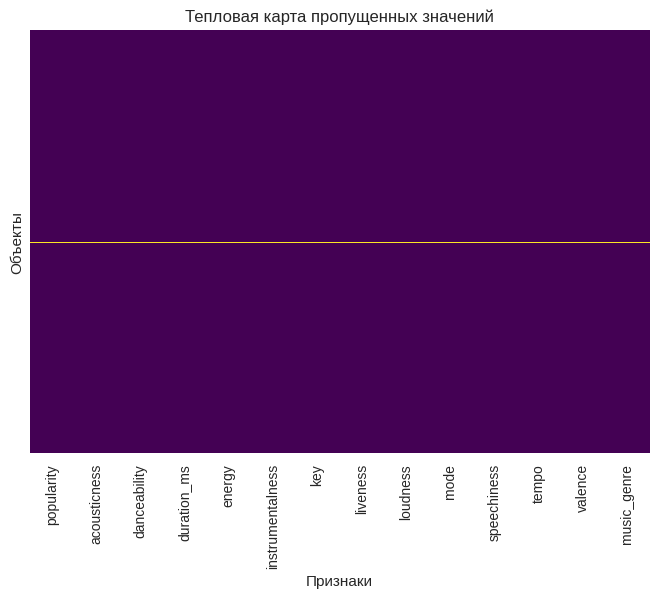

In [17]:
sns.heatmap(df[9000:11000].isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений')
plt.xlabel('Признаки')
plt.ylabel('Объекты')
plt.show()

Видно, что значения пропущены равномерно и не имеют никакого значения, следовательно, они могут быть спокойно удалены.

In [18]:
df = df.dropna()

In [19]:
print(f'Количетсво пропущенных значений {df.isna().sum().sum()}')
df.isna().sum()

Количетсво пропущенных значений 0


,0
popularity,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0
loudness,0
mode,0


### Значения, не указанные явно как NaN

Теперь проверим, нет ли отсутствующих значений не обозначенных, как NaN.

In [20]:
categorical_data.describe()

,artist_name,track_name,key,mode,tempo,music_genre
count,50000,50000,50000,50000,50000,50000
unique,6863,41699,12,2,29394,10
top,empty_field,Home,G,Major,?,Electronic
freq,2489,16,5727,32099,4980,5000


Можно заметить, в признаке **'tempo'** пропущенные значения обозначены символом '?' и их 4980.

In [21]:
non_trivial_nans_df = df[df['tempo'] == '?']

In [22]:
(df['tempo'] == '?').value_counts(normalize=True)

,proportion
tempo,
False,0.9004
True,0.0996


<Axes: >

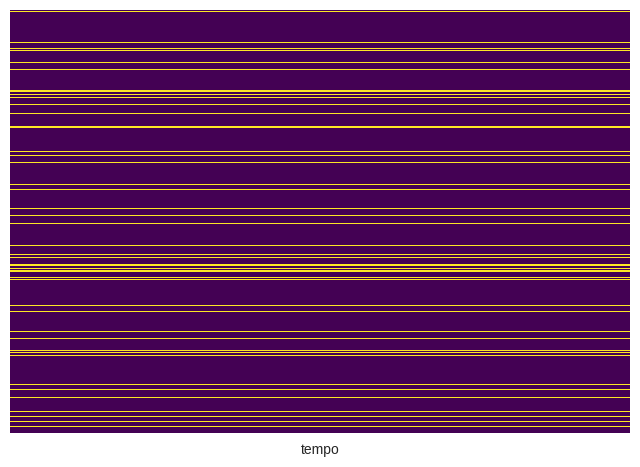

In [23]:
non_trivial_nans = (df['tempo'] == '?')
missing_values_df = non_trivial_nans.to_frame()

sns.heatmap(missing_values_df, yticklabels=False, cbar=False, cmap='viridis')

Предварительно, посмотрим на распределение признака **'tempo'**.

<Axes: xlabel='tempo', ylabel='Count'>

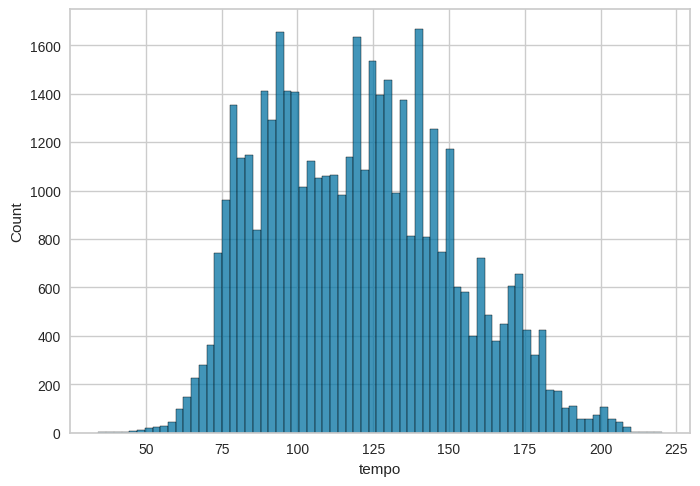

In [24]:
tempo = df['tempo'].replace('?', np.nan)
tempo_float = tempo.astype(float)
sns.histplot(tempo_float)

Так как неизвестных значений довольно много (почти 10%) замена на среднее или медиану может сильно исказить распределение. По этой причине произведем замену случайным значением из распределения.

In [25]:
num = pd.to_numeric(df['tempo'], errors='coerce')

In [26]:
filler = num[num.isna()]
filler

,tempo
5,NaN
32,NaN
35,NaN
36,NaN
39,NaN
...,...
49918,NaN
49964,NaN
49967,NaN
49976,NaN


In [27]:
filler_new = num[~num.isna()].sample(n=len(filler)).set_axis(filler.index)
filler_new

,tempo
5,134.002
32,107.990
35,101.992
36,141.819
39,150.060
...,...
49918,114.000
49964,113.133
49967,85.335
49976,122.733


In [28]:
df.tempo = num.fillna(filler_new)

<Axes: xlabel='tempo', ylabel='Count'>

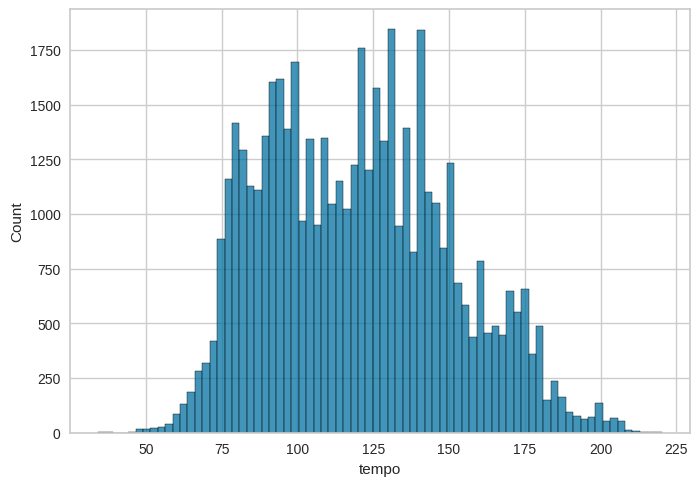

In [29]:
sns.histplot(df.tempo)

Распределение в целом не поменялось.

В признаке **'duration_ms'** отсутсвующие значения отмечены значением '-1'.  
 Посмотрим на распределение и сделаем вывод о методы заполнения отсутствующих значений.

In [30]:
df['duration_ms'].describe()

,duration_ms
count,5.000000e+04
mean,2.212526e+05
std,1.286720e+05
min,-1.000000e+00
25%,1.748000e+05
50%,2.192810e+05
75%,2.686122e+05
max,4.830606e+06


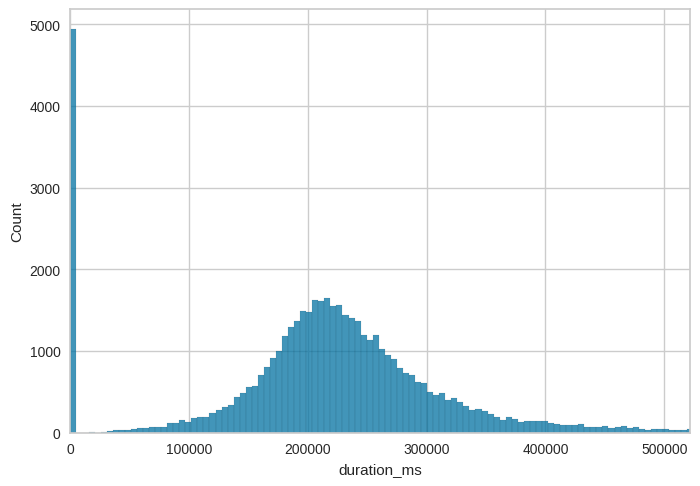

In [31]:
sns.histplot(df['duration_ms'])
plt.xlim(0, 5.22e+05)
plt.show()

Заменим случайным, чтобы сохранить нормальность распределения.

In [32]:
df['duration_ms'].replace(-1, pd.NA, inplace=True)

In [33]:
filler = df['duration_ms'][df['duration_ms'].isna()]
filler

,duration_ms
0,NaN
13,NaN
16,NaN
24,NaN
35,NaN
...,...
49956,NaN
49969,NaN
49979,NaN
49981,NaN


In [34]:
filler_new = df['duration_ms'][~df['duration_ms'].isna()].sample(n=len(filler)).set_axis(filler.index)
filler_new

,duration_ms
0,265179.0
13,194293.0
16,261267.0
24,225947.0
35,260303.0
...,...
49956,234387.0
49969,167307.0
49979,195918.0
49981,161595.0


In [35]:
df['duration_ms'] = df['duration_ms'].fillna(filler_new)

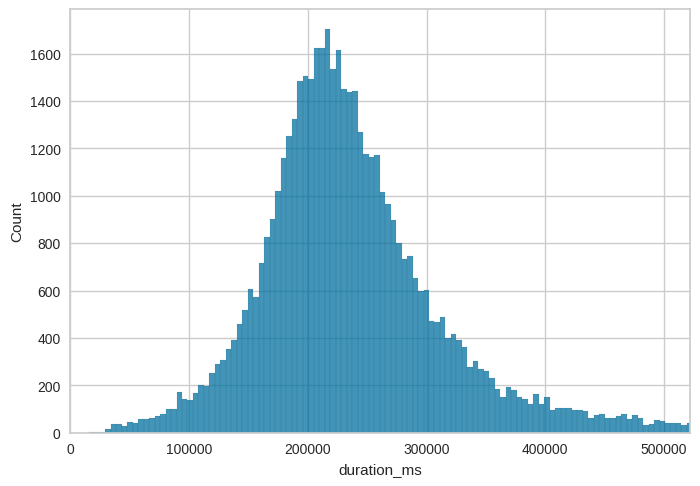

In [36]:
sns.histplot(df['duration_ms'])
plt.xlim(0, 5.22e+05)
plt.show()

Замена на случайное значение сохранило нормальное распределение.

## Физический смысл признаков

In [37]:
df.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'music_genre'],
      dtype='object')

**'instance_id'** - уникальный идентификатор объекта  
**'artist_name'** - имя артиста  
**'track_name'** - название трека  
**'popularity'** - популярность трека  
**'acousticness'** - акустичность трека (используются исключительно или по большей части инструменты, воспроизводящие звук с помощью акустических средств, а не электрических или электронных.)  
**'danceability'** - оценивает, насколько подходящий трек для танцев, основываясь на комбинации музыкальных элементов, включая темп, стабильность ритма, сила удара и общую регулярность.  
**'duration_ms'** - длительность трека в миллисекундах  
**'energy'** - представляет собой воспринимаемую меру интенсивности и активности. Обычно энергичные треки ощущаются быстрыми, громкими и шумными. Например, дэт-металл обладает высокой энергией, в то время как прелюдия Баха набирает низкие баллы по шкале.  
**'instrumentalness'** - инструментальность трека (Чем ближе значение инструментальности к 1.0, тем выше вероятность, что в треке отсутствует вокальное содержание.)  
**'key'** -  знак линейной нотации, определяющий звуковысотное значение нот. (отсутствие ключа обозначается "-1")  
**'liveness'** - более высокие значения указывают на большую вероятность того, что трек был исполнен живьем.  
**'loudness'** - громкость трека в децибелах  
**'mode'** - модальность  
**'speechiness'** - мера разговорности в треке (насколько в треке много разговоров)  
**'tempo'** - тепм в ударах в минуту  
**'obtained_date'** - дата получения трека  
**'valence'** - Показатель, описывающий музыкальную положительность, передаваемую треком. Треки с высоким показателем валентности звучат более положительно (например, весело, радостно, эйфорично), в то время как треки с низким показателем валентности звучат более негативно (например, грустно, подавленно, злобно).

## Преобразование категориальных признаков

In [38]:
object_columns = df.select_dtypes(include=['object']).columns
object_columns

Index(['key', 'mode', 'music_genre'], dtype='object')

In [39]:
df[object_columns].describe()

,key,mode,music_genre
count,50000,50000,50000
unique,12,2,10
top,G,Major,Electronic
freq,5727,32099,5000


Преобразуем категориальные признаки в численные.  
Из них можно выделить **'mode'** как бинарный признак.

### Преобразование бинарных признаков

In [40]:
df['mode']

,mode
0,Minor
1,Minor
2,Major
3,Major
4,Major
...,...
50000,Major
50001,Major
50002,Major
50003,Minor


In [41]:
le = LabelEncoder()
mode_enc = le.fit_transform(df['mode'])
mode_enc

array([1, 1, 0, ..., 0, 1, 1])

In [42]:
df['mode'] = mode_enc
df

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,265179.0,0.941,0.79200,A#,0.115,-5.201,1,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,1,0.0300,115.002,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,0,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,0,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,0,0.0413,145.036,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,59.0,0.03340,0.913,240440.0,0.574,0.00000,C#,0.119,-7.022,0,0.2980,98.028,0.330,Hip-Hop
50001,72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,0,0.0550,122.043,0.113,Hip-Hop
50002,51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,0,0.1460,131.079,0.395,Hip-Hop
50003,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,1,0.0441,75.886,0.354,Hip-Hop


### Преобразование номинальных признаков

Закодируем **'key'** с помощью *OneHotEncoder*.

In [43]:
OH_key = OneHotEncoder(sparse_output=False)

In [44]:
dummies = pd.DataFrame(OH_key.fit_transform(df[['key']]),
                       columns=OH_key.get_feature_names_out(['key']),
                       index = df.index)

In [45]:
df_dum = pd.concat([df, dummies], axis=1).drop(['key'], axis=1)

In [46]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 50004
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       50000 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   liveness          50000 non-null  float64
 7   loudness          50000 non-null  float64
 8   mode              50000 non-null  int64  
 9   speechiness       50000 non-null  float64
 10  tempo             50000 non-null  float64
 11  valence           50000 non-null  float64
 12  music_genre       50000 non-null  object 
 13  key_A             50000 non-null  float64
 14  key_A#            50000 non-null  float64
 15  key_B             50000 non-null  float64
 16  key_C             50000 non-null  float64
 17

Все категориальные признаки преобразованы в числовые;  
 все отсутствующие значения заполнены;

# 3. Описательный анализ и визуализация

### Распределение численных признаков

In [47]:
num_cols = df_dum.columns[:12]
num_cols.shape

(12,)

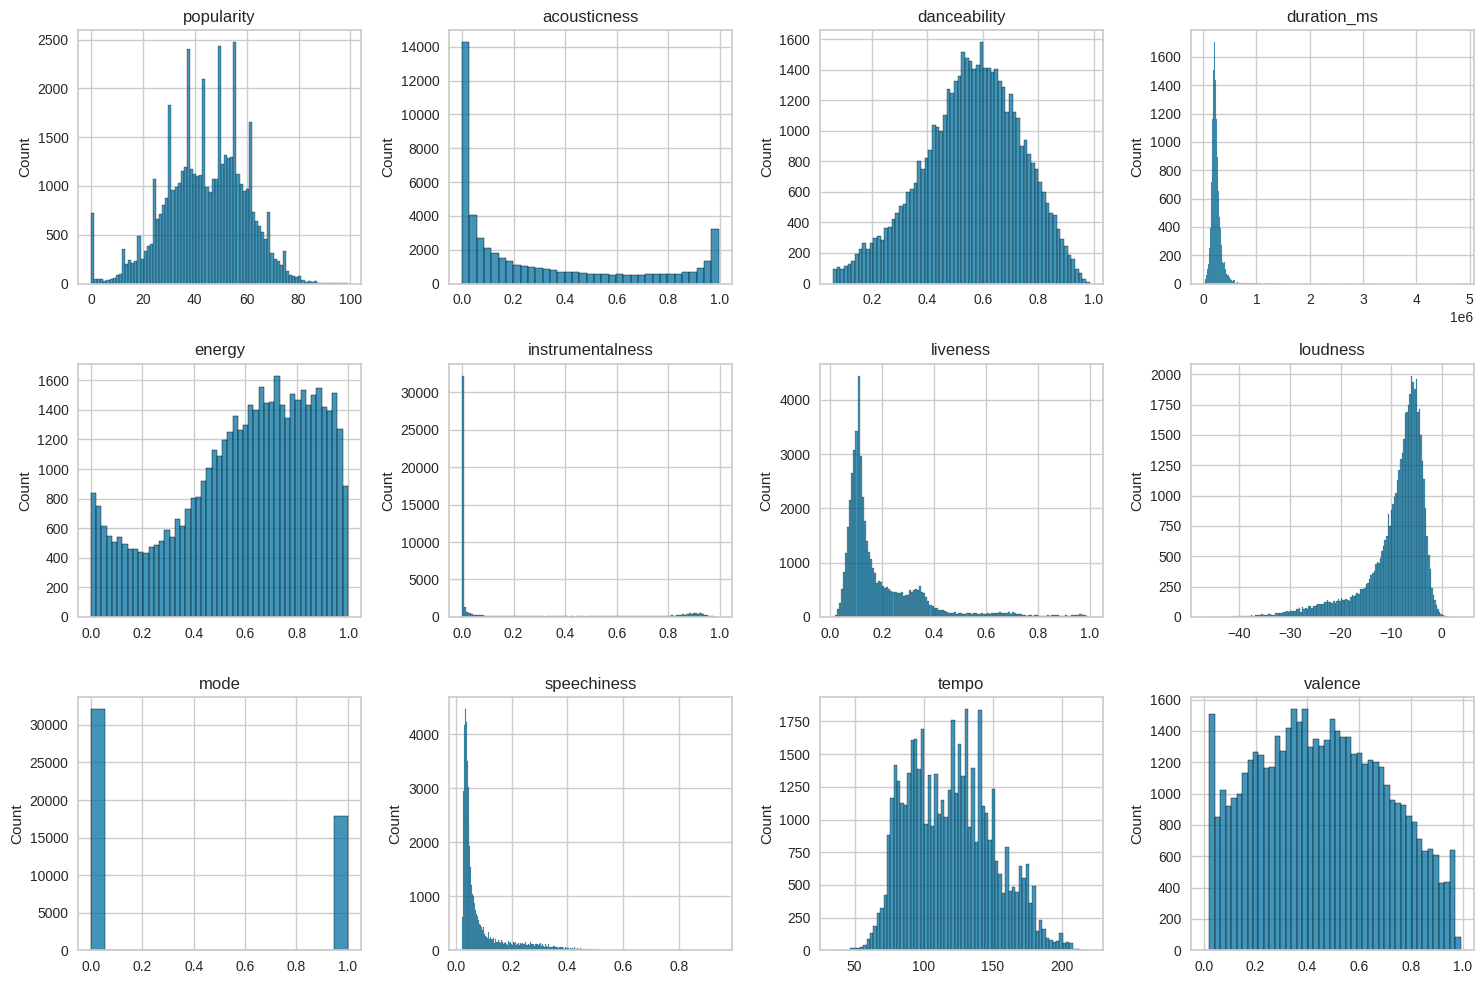

In [48]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df_dum[col], ax=axes[i])
    axes[i].set_title(col)  # Set title as column name
    axes[i].set_xlabel('')  # Remove x-axis label for better visualization

plt.tight_layout()
plt.show()

### Распределение категориальных признаков

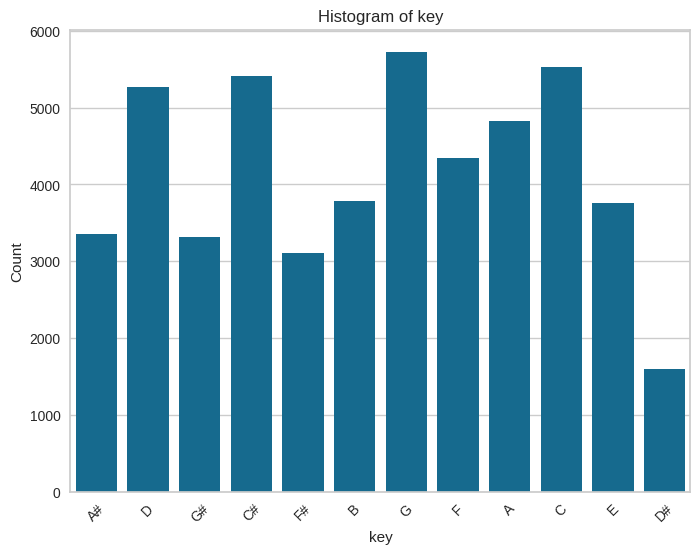

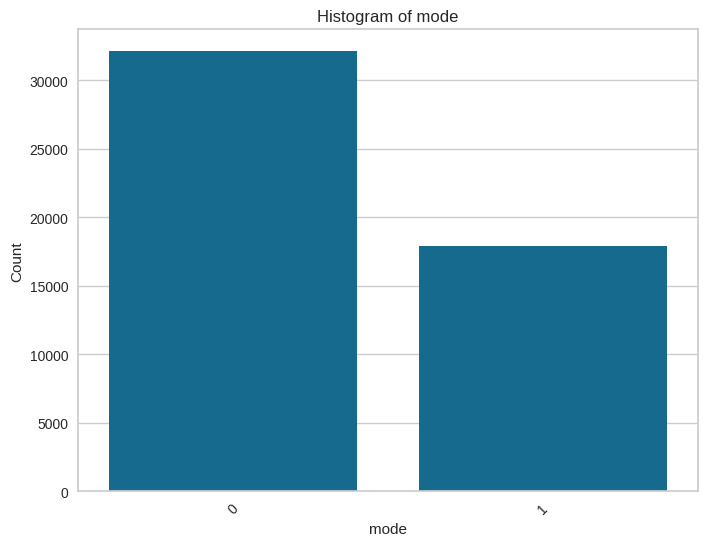

In [49]:
categorical_columns = ['key', 'mode']

for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=df)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

### Совместное распределение призаков с целевой переменной

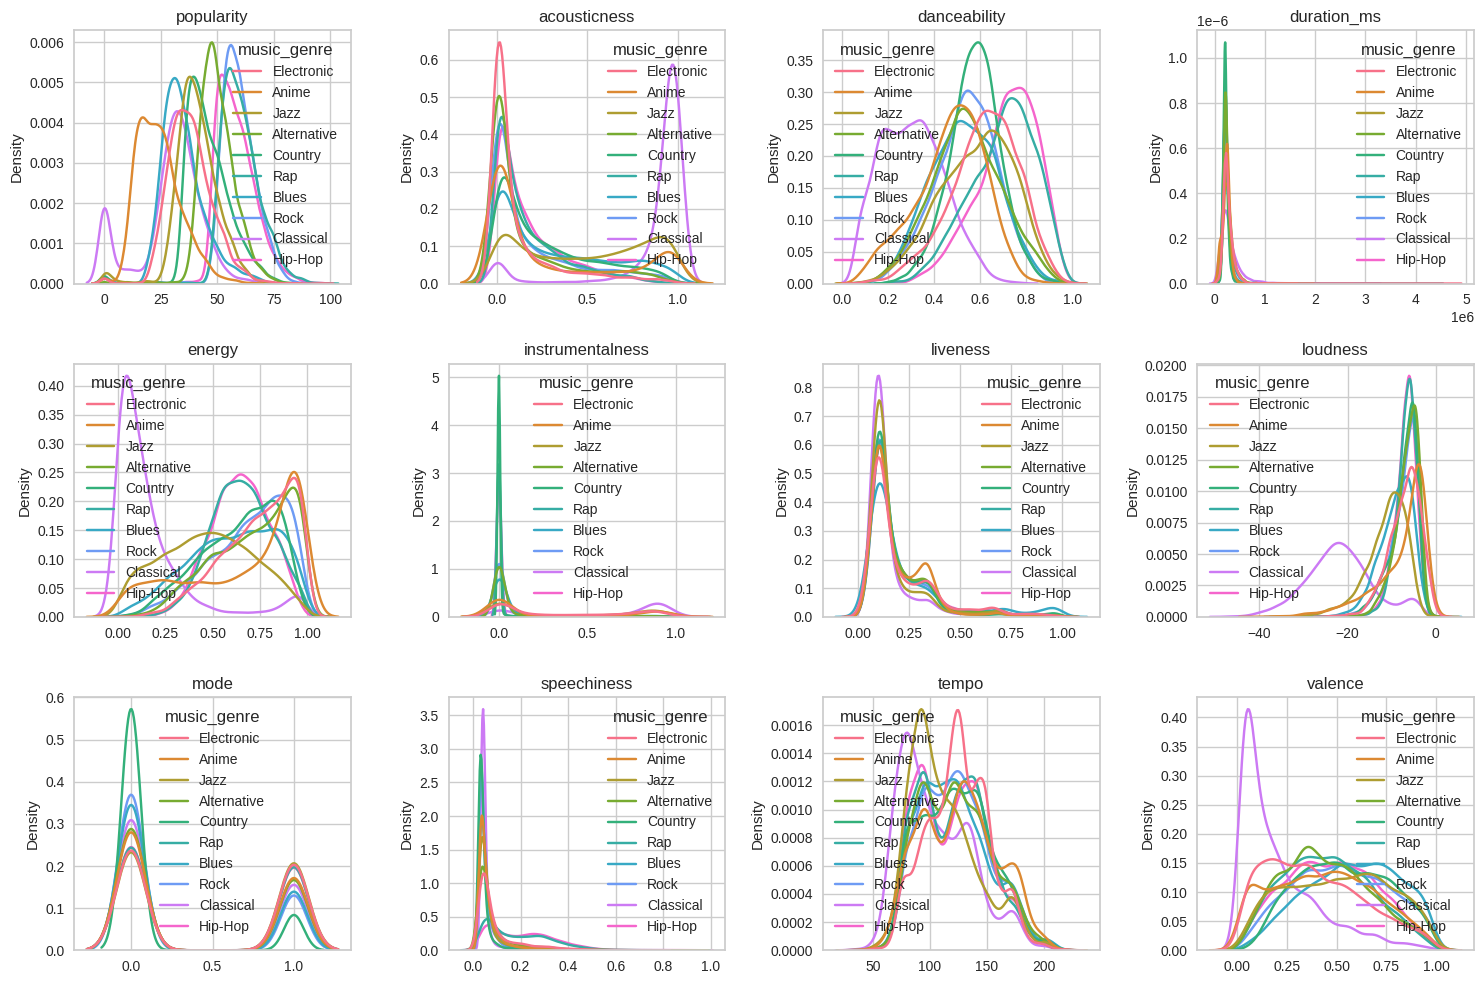

In [50]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=df_dum, x=col, hue="music_genre", ax=axes[i])
    axes[i].set_title(col)  # Set title as column name
    axes[i].set_xlabel('')  # Remove x-axis label for better visualization

plt.tight_layout()
plt.show()

Графики плоности показывают, что признаки '**duration_ms**', '**liveness**', '**mode**' и '**speechiness**' не имеют ярко выделенных участков на горизонтальной оси, на которых соотношение существенно отличается.  
Из этого можно сделать вывод, что изолированно данные атрибуты не сильно влияют на значение целевой переменной.  
Удалять данные признаки мы пока не станем, проведем дополнительный анализ.


### Выявление коррелированных признаков

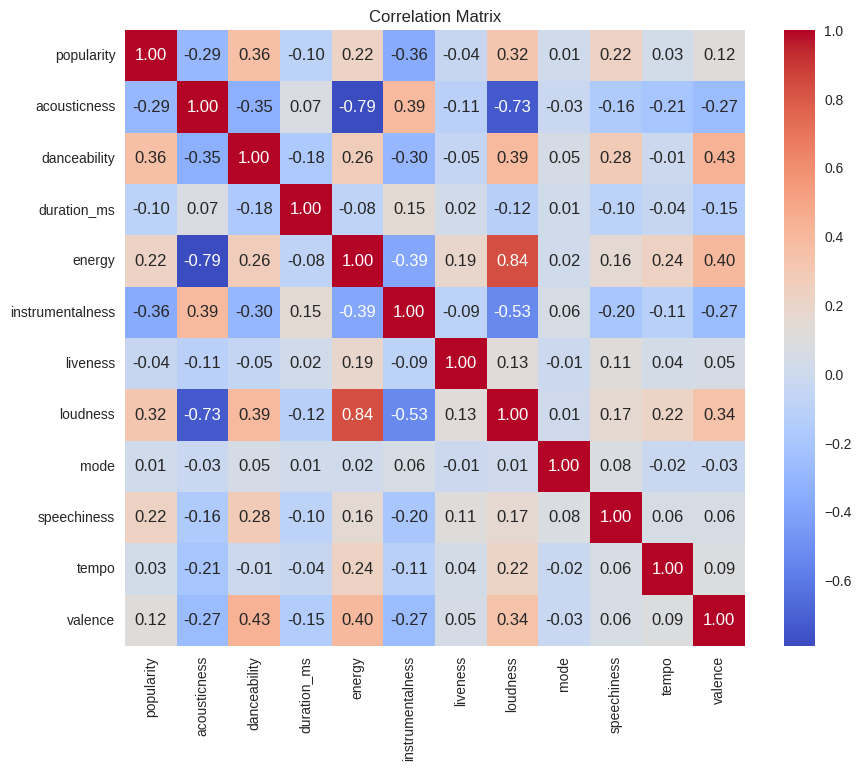

In [51]:
correlation_matrix = df_dum[num_cols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Можно заметить сильную связь между парами признаков: '**loudness**' и '**energy**', '**acousticness**' и '**energy**'.

### Обучение моделей и анализ результатов в файле "Model Selection and Results"